In [1]:
import sys
import os
import glob
# sys.path.append('../')
# sys.path.append('../modules/')
# sys.path.append('../util/')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import random
from natsort import natsorted

from SFM_Finetune import models_Segmentation
from SFM_Pretrain import models_mae
from modules.modeling.deeplab import *
from modules.modeling.Unet_models import *
from util.metrics import *

pwd = os.getcwd()

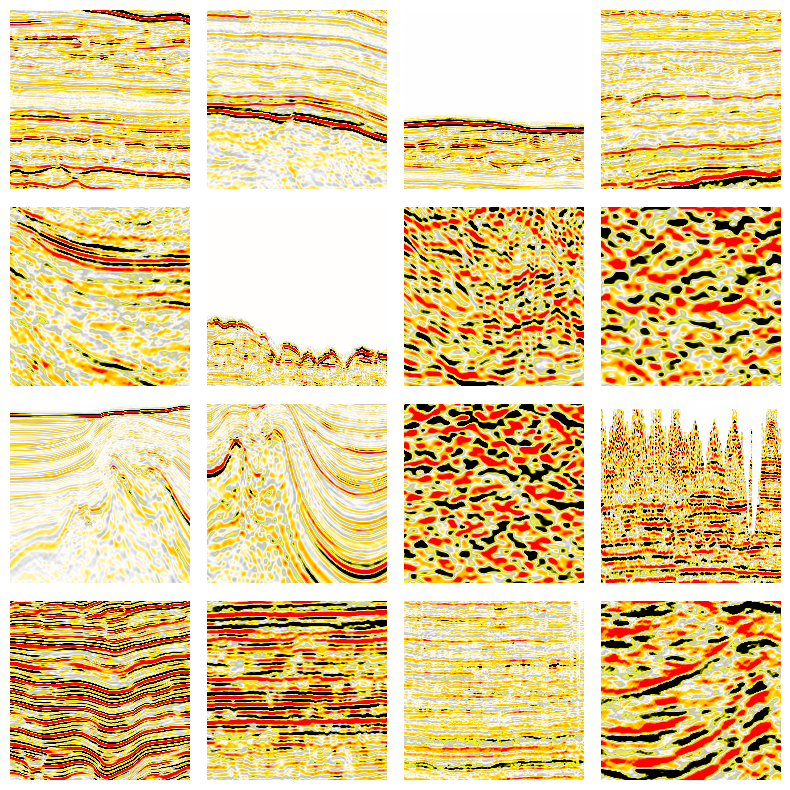

In [2]:
color_list = ['black','yellow','silver','white','gold','orange','red']
cmap = mpl.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)


data_path = os.path.join(pwd, 'mae_data_more')
data_files = natsorted(glob.glob(os.path.join(data_path, '*.dat')))
# selected_files = random.sample(data_files, 16) # Random Select files to show
selected_files = data_files[:16]

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=np.array((10, 10)) * 0.8)
for i, ax in enumerate(axes.flatten()):
    with open(selected_files[i], 'rb') as f:
        data = np.fromfile(f, dtype=np.single)
        img_size = int(np.sqrt(data.size))
        data = data.reshape((img_size, img_size))
        ax.imshow(data, cmap=cmap, vmin=np.min(data)/3,vmax=-np.min(data)/3)
        ax.axis('off')
# 显示整个图像
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [5]:
def prepare_model(chkpt_dir, arch='vit_large_patch16', img_size=768):
    # 检查是否有可用的GPU
    if torch.cuda.is_available():
        # 获取GPU的数量
        num_gpus = torch.cuda.device_count()
        print(f"Number of GPUs available: {num_gpus}")
    
        # 遍历每个GPU并打印详细信息
        for i in range(num_gpus):
            print(f"GPU {i} details:")
            # 获取GPU的名称
            gpu_name = torch.cuda.get_device_name(i)
            print(f"  Name: {gpu_name}")
            # 获取GPU的计算能力
            gpu_capability = torch.cuda.get_device_capability(i)
            print(f"  Compute Capability: {gpu_capability[0]}.{gpu_capability[1]}")
            # 获取GPU的显存总量
            gpu_memory = torch.cuda.get_device_properties(i).total_memory
            print(f"  Total Memory: {gpu_memory / 1e9:.2f} GB")
            # 获取GPU的当前占用显存
            gpu_current_memory = torch.cuda.memory_allocated(i)
            print(f"  Current Memory Allocated: {gpu_current_memory / 1e9:.2f} GB")
            # 获取GPU的当前缓存显存
            gpu_cached_memory = torch.cuda.memory_reserved(i)
            print(f"  Current Memory Cached: {gpu_cached_memory / 1e9:.2f} GB")

        # 选择内存使用量最小的显卡
        num_gpus = torch.cuda.device_count()
        min_memory_usage = float('inf')
        selected_gpu = None    
        for i in range(num_gpus):
            memory_allocated = torch.cuda.memory_allocated(i)
            if memory_allocated < min_memory_usage:
                min_memory_usage = memory_allocated
                selected_gpu = i
        print("GPU %d is selected." % selected_gpu)
        device = torch.device(f'cuda:{selected_gpu}')
    else:
        print("No GPU available.")
        device = torch.device('cpu')
    
    # device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # device = torch.device('cpu')

    model = getattr(models_mae, arch)(norm_pix_loss=False, in_chans=1)

    checkpoint = torch.load(chkpt_dir, map_location=device)
#     interpolate_pos_embed(model, checkpoint['model'])
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    model.to(device)
    return model 

In [6]:
chkpt_dir = '/home/zhangji/LLM/Geophysics/SeismicFoundationModel/SFM_Pretrain/output_dir/checkpoint-0.pth' 
model_SFM = prepare_model(chkpt_dir, 'mae_vit_tiny_patch16', img_size=224)

Number of GPUs available: 2
GPU 0 details:
  Name: NVIDIA GeForce RTX 2080 Ti
  Compute Capability: 7.5
  Total Memory: 11.55 GB
  Current Memory Allocated: 0.00 GB
  Current Memory Cached: 0.00 GB
GPU 1 details:
  Name: NVIDIA GeForce RTX 2080 Ti
  Compute Capability: 7.5
  Total Memory: 11.55 GB
  Current Memory Allocated: 0.00 GB
  Current Memory Cached: 0.00 GB
GPU 0 is selected.
<All keys matched successfully>


In [40]:
import matplotlib as mpl
color_list = ['black','yellow','silver','white','gold','orange','red']
cmap = mpl.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)

def show_image(image, vmin=None, vmax=None, title='', figsize=None,cmap=None):
    if figsize is not None:
        plt.figure(figsize=figsize)
    if cmap:
        plt.imshow(image, cmap=cmap, interpolation='bicubic', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(image, interpolation='bicubic', vmin=vmin, vmax=vmax)
    plt.title(title)
#     plt.axis('off')
    # plt.show()
    return
    
def run_one_image(img, model):
    device = next(model.parameters()).device
    
    x = torch.tensor(img).to(device)
    x = x.unsqueeze(0)
    x = x.unsqueeze(0)
    model_SFM.eval()
    pred = model_SFM(x)
    pred = pred[1].detach().cpu()
    pred = pred.squeeze(0).reshape(img.shape)
    # pred = pred.squeeze(0)
    print(pred.shape)

    plt.rcParams['figure.figsize'] = [15, 10]
    plt.subplot(1, 2, 1)
    show_image(img, vmin=x.min()/12, vmax=x.max()/12, title="Seismic",cmap=cmap)
    
    plt.subplot(1, 2, 2)
    show_image(pred, cmap=cmap, title="Prediction")

torch.Size([224, 224])


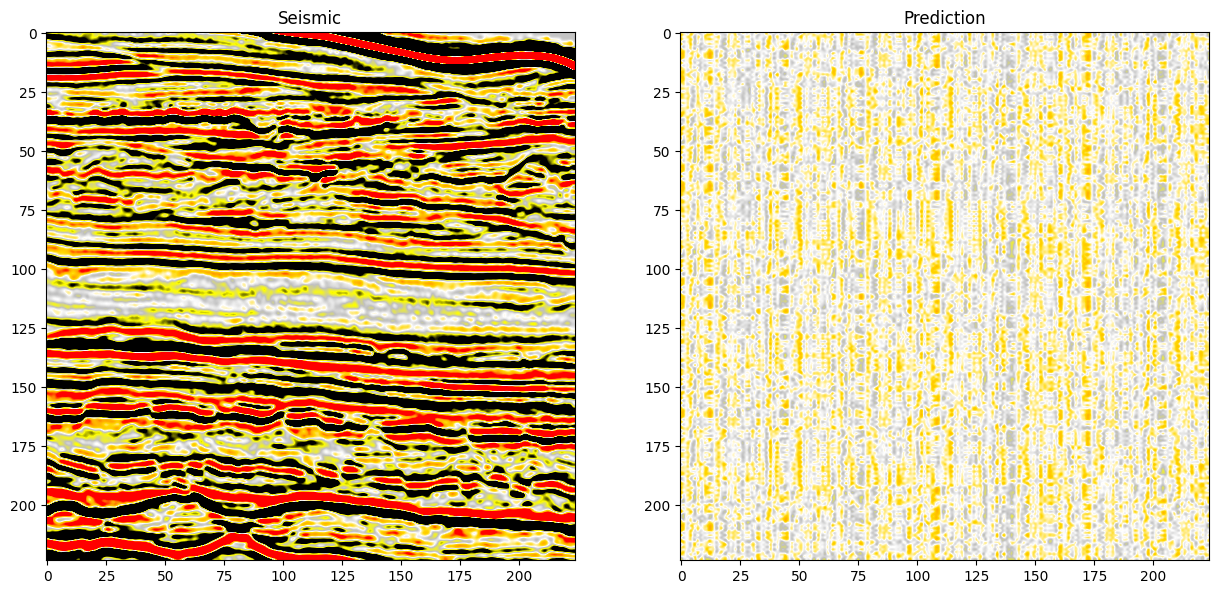

In [41]:
data_list = data_files
dnum = 0

d = np.fromfile(data_list[dnum], np.float32)
img_size = int(np.sqrt(d.size))
d = d.reshape((img_size, img_size))
run_one_image(d, model_SFM)